In [24]:
'''
Author: Sashka Warner and Jacob Cytrynbaum
Desc: Code to run heart rate prediction model
Notes: 
- This code is based on athlete_hr_predict (MIT license) by rikluost (https://github.com/rikluost/athlete_hr_predict). 
- The athlete_hr_predict license is included below:


MIT License

Copyright (c) 2021 Riku

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.'''

'\nAuthor: Sashka Warner and Jacob Cytrynbaum\nDesc: Code to run heart rate prediction model\nNotes: \n- This code is based on athlete_hr_predict (MIT license) by rikluost (https://github.com/rikluost/athlete_hr_predict). \n- The athlete_hr_predict license is included below:\n\n\nMIT License\n\nCopyright (c) 2021 Riku\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LI

In [35]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy
import seaborn as sns
import statsmodels.api as sm

In [2]:
# location of the fit files
fit_path = "../activity_data/jacob_cytrynbaum/fit_file_csv/"
fit_path_clean = "../activity_data/jacob_cytrynbaum/fit_file_clean_csv/"
fit_test_path = "../activity_data/jacob_cytrynbaum/fit_file_test_csv/"
graph_path = "../graphs"
#os.chdir(fit_path)

if(not os.path.exists(fit_path_clean)):
    print('Creating new clean data folder...')
    os.mkdir(fit_path_clean)

In [3]:
# add calculated altitude difference column, and 5sec moving average column. Remove geographical coordinates for privacy.
fit_files = glob.glob(f"{fit_path}*.csv")
for file in fit_files:
    df = pd.read_csv(file)
    #print(file)
    df.index = df['time'].astype(np.int32)
    df['alt_difference'] = df['altitude'] - df['altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df = df.drop(['latlng', 'time'], axis=1, errors='ignore')
    #print(df.head())
    print(fit_path_clean + os.path.basename(file))
    df.to_csv(fit_path_clean + os.path.basename(file))


../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2023-01-28T15.30.11GMT_Lindseyranak.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-10-20T22.25.21GMT_Workout.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-11-27T16.18.33GMT_MorningRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-11-02T01.21.04GMT_EveningRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-11-10T14.24.34GMT_MorningRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-10-15T19.55.29GMT_LunchRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-11-28T23.15.04GMT_AfternoonRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-11-04T00.42.22GMT_AfternoonRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-10-12T11.04.52GMT_MorningRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-10-30T15.19.37GMT_MorningRun.csv
../activity_data/jacob_cytrynbaum/fit_file_clean_csv/2022-12-07T15.17.49GMT_MorningRun.cs

In [4]:
# set parameters, file names

#select the features for EDA graphs:
eda_model_features =  [
    "heartrate", 
    "velocity_smooth",
    "rolling_ave_alt", 
    "distance", 
    "altitude"]

#select the predictors for the model:
all_cols = ["heartrate", "velocity_smooth","rolling_ave_alt"]
#model_features =  ["heartrate", "velocity_smooth","rolling_ave_alt"] #  cadence, altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt
model_features =  ["velocity_smooth","rolling_ave_alt"]
batch_size = 250 # training batch size for the LSTM
epochs = 180 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.001
decay_rate = 0.001
n_X = 120 # number of timesteps for training
n_y = 22 # number of timesteps in future for prediction
step = 1 # step size of predictors for model training

sequence_length = int(n_X/step)
# NOTE: Could put the test files in a separate directory...
# n_validation was 10, just splitting that in two for now - revist this later
n_validation = 5 # number of files for validation dataset (only 1 validation file supported at the moment)
n_test = 5

# select the training files and the validation files 
all_files = glob.glob(fit_path_clean+"/*.csv")
train_files = glob.glob(fit_path_clean+"/*.csv")[0:-(n_validation + n_test)]
validation_files = glob.glob(fit_path_clean+"/*.csv")[-(n_validation + n_test):-n_test]
test_files = glob.glob(fit_path_clean+"/*.csv")[-n_test:]
#test_files = glob.glob(fit_test_path+"/*.csv")

In [5]:
# calculate the data normalisation parameters from all training data

# Standard Scaler
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(file)
    df.index = df['time'].astype(np.int32)
    df = df.drop(['time'], axis=1, errors='ignore')
    df = df[all_cols]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

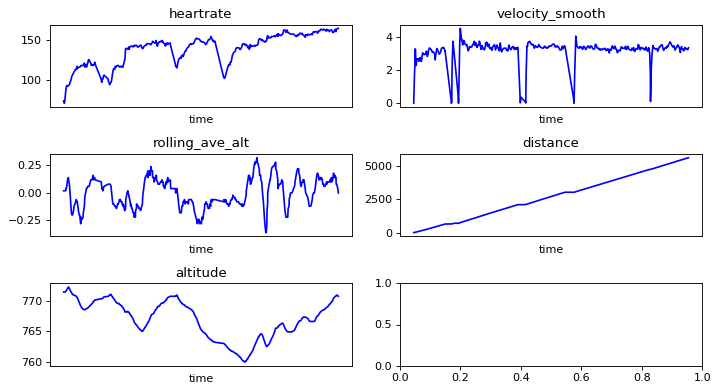

In [6]:
# Exploratory Data Analysis
eda_example = pd.read_csv(fit_path_clean+"/2022-10-04T14.22.18GMT_MorningRun.csv", index_col='time')[eda_model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=int(len(eda_model_features)/2+0.5), ncols=2, figsize=(9, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(eda_model_features)):
        key = eda_model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)
plt.savefig(graph_path+"/HR_eda.png")


In [7]:
# validation dataset - train each file at the time
n=0
for file in validation_files:
    df = pd.read_csv(file, index_col='time')[all_cols] # e.g. shape: (265, 3)
    df_scale = (df - df_mean) / df_std
    #start = n_X + n_y # n timesteps for training + n timesteps for prediction e.g.  142
    #end = n_X + len(df.index) # n timesteps for training + number of rows in df e.g. 385
    
    #x = df_scale[model_features].values
    x = df_scale[model_features].iloc[:-(n_X + n_y)].values
    #y = df_scale.iloc[start:end][["heartrate"]]
    y = df_scale.iloc[n_X:][["heartrate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x, # features
        y, # targets
        sequence_length=sequence_length, # Length of output sequences in number of time steps, here sequence length is same as n_X
        sampling_rate=step, # Period between successive timesteps within sequences
        batch_size=batch_size, # Number of timeseries samples in each batch
    )
    if n==0 :
        print(df.shape, x.shape, y.shape)
        dataset_val_old = dataset_val
    if n>0 : dataset_val_old = dataset_val.concatenate(dataset_val_old)
    
    n=n+1

dataset_val = dataset_val_old

2023-02-22 17:27:18.223720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(265, 3) (123, 2) (145, 1)


In [8]:
# Calculate statistics for the naive model
# make dataframe for the naive model
d_naive = pd.DataFrame(columns=['measured', 'predicted'])
d_naive['measured']=denormalize_hr(x[n_y:,0])
d_naive['predicted']=denormalize_hr(x[:-n_y,0])

y_test, pred_test = d_naive['measured'].values, d_naive['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))

print('Naive model\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))

Naive model
MAE = 36.134, MSE = 2816.965
Mean and 95% prediction interval = -1.2581650405964016 +/- 103.99794208415744
Uncertainty of mean = 5.610486446811358


In [9]:
#Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
! rm -rf ./logs/

# Get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# Define the model architecture
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
outputs = keras.layers.LSTM(4, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(outputs)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Learning rate schedule so we can lower the learning rate as the training progresses
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=50000,
    decay_rate=0.001)

# Name of file for saving model checkpoint
path_checkpoint = "model_checkpoint.h5"

# For early stopping
es_callback = keras.callbacks.EarlyStopping(monitor="val_mae", min_delta=0, patience=5, verbose=1)

# For visualizations of model performance with tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to save the model at the "best" point
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_mae",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# C
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["mae"], loss="mae")

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 4)                 112       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [10]:
# training dataset

n=0
for file in train_files:
    df = pd.read_csv(file, index_col='time')[all_cols]
    df = (df - df_mean) / df_std
    #print(file)
    #start = n_X + n_y
    #end = n_X + len(df.index)
    
    #x = df[model_features].values
    #y = df.iloc[start:end][["heartrate"]].values
    x = df_scale[model_features].iloc[:-(n_X + n_y)].values
    y = df_scale.iloc[n_X:][["heartrate"]]
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size
    )
    
    if n==0 : dataset_train_old = dataset_train
    if n>0 : dataset_train_old = dataset_train.concatenate(dataset_train_old)

    n=n+1

dataset_train=dataset_train_old

len(dataset_train)


30

In [11]:
# train the model, with tensorboard visualisations
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback, tensorboard_callback],
    verbose=1
)

Epoch 1/180
29/30 [============================>.] - ETA: 0s - loss: 0.8042 - mae: 0.8042
Epoch 1: val_mae improved from inf to 1.27721, saving model to model_checkpoint.h5
30/30 [==============================] - 4s 61ms/step - loss: 0.7946 - mae: 0.7946 - val_loss: 1.2772 - val_mae: 1.2772
Epoch 2/180
29/30 [============================>.] - ETA: 0s - loss: 0.3996 - mae: 0.3996
Epoch 2: val_mae did not improve from 1.27721
30/30 [==============================] - 1s 45ms/step - loss: 0.3966 - mae: 0.3966 - val_loss: 1.5370 - val_mae: 1.5370
Epoch 3/180
29/30 [============================>.] - ETA: 0s - loss: 0.2183 - mae: 0.2183
Epoch 3: val_mae did not improve from 1.27721
30/30 [==============================] - 1s 45ms/step - loss: 0.2170 - mae: 0.2170 - val_loss: 1.7139 - val_mae: 1.7139
Epoch 4/180
30/30 [==============================] - ETA: 0s - loss: 0.1597 - mae: 0.1597
Epoch 4: val_mae did not improve from 1.27721
30/30 [==============================] - 1s 45ms/step - los

In [12]:
%tensorboard --logdir logs/fit

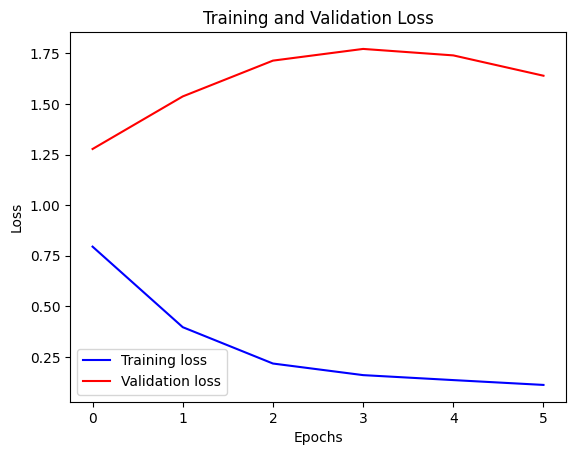

In [13]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

visualize_loss(history, "Training and Validation Loss")
plt.savefig(graph_path+'/HR_his_t'+str(n_y)+".png")

In [17]:
# Check predictions visually
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='time')[model_features]
    df = (df - df_mean) / df_std
    #print(file)
    #start = n_X + n_y
    #end = n_X + len(df.index)
    
    #x = df[model_features].values
    #y = df.iloc[start:end][["heartrate"]].values
    x = df_scale[model_features].iloc[:-(n_X + n_y)].values
    y = df_scale.iloc[n_X:][["heartrate"]]
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=10
    )
    
    if n>0:
        dataset_test_old = dataset_train_old.concatenate(dataset_test)
    
    dataset_test_old = dataset_test
    
    n=n+1
dataset_test = dataset_test_old

1/1 [==============================] - 0s 23ms/step


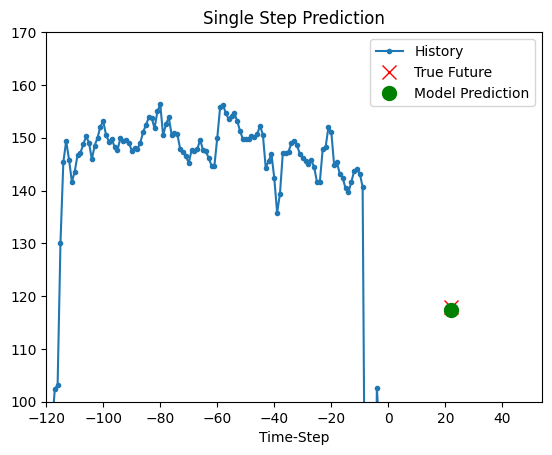

1/1 [==============================] - 0s 24ms/step


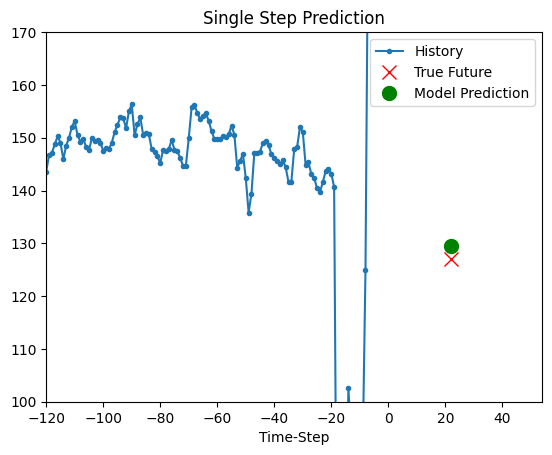

1/1 [==============================] - 0s 23ms/step


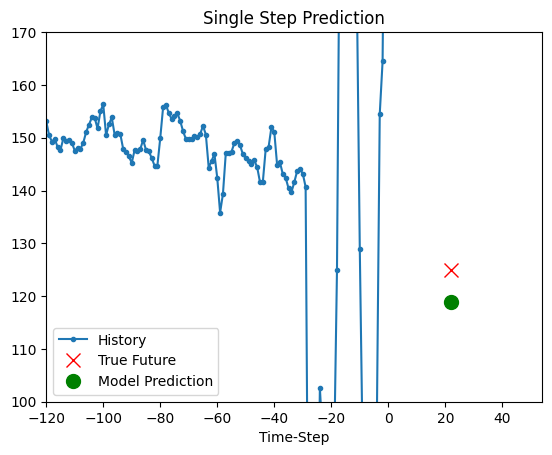

1/1 [==============================] - 0s 43ms/step


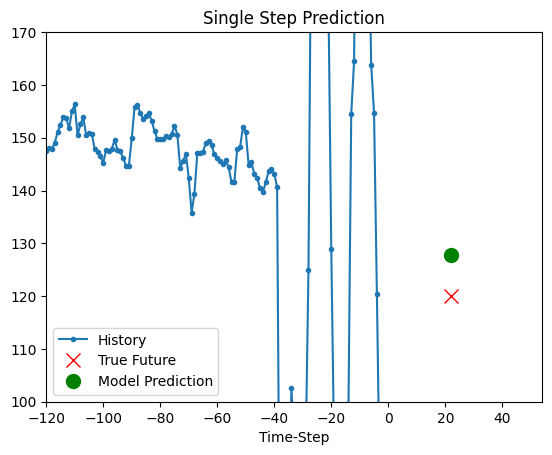

1/1 [==============================] - 0s 29ms/step


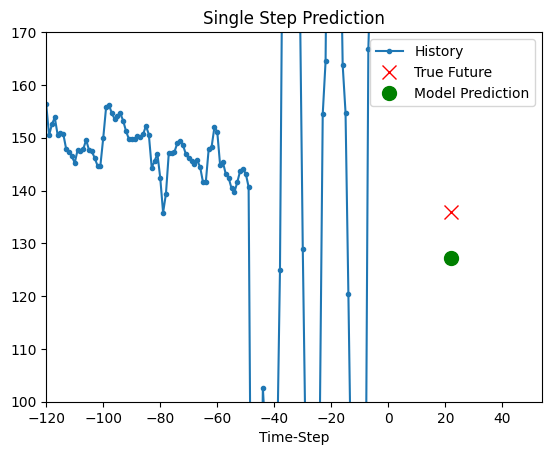

In [18]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        n_y,
        "Single Step Prediction",
    )

In [28]:
# Model evaluation
# create a testing dataset from the kept-aside files
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='time')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    #x = df[model_features].values
    #y = df.iloc[start:end][["heartrate"]].values
    x = df_scale[model_features].iloc[:-(n_X + n_y)].values
    y = df_scale.iloc[n_X:][["heartrate"]]
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=1
    )
    
    if n==0 : dataset_test_old = dataset_test
    if n>0 : dataset_test_old = dataset_test_old.concatenate(dataset_test)
    
    n=n+1
dataset_test = dataset_test_old

# make a dataframe with predictions and observations
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr(model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']
d = d.bfill()


1/1 [==============================] - 0s 22ms/step


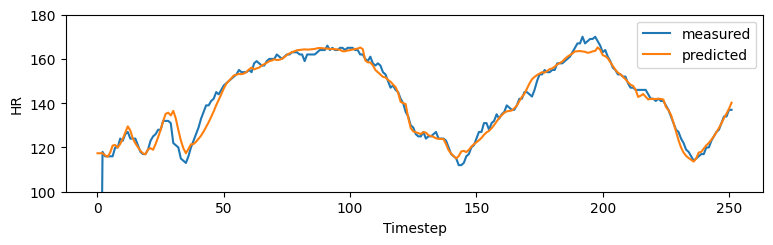

In [30]:
# time domain plot with observed blue, and predicted orange. Predicted is calculated values where previous 30sec of inputs are missing.
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(9, 2.3)
d.plot(ylim=(100,180), xlabel='Timestep', ylabel='HR', ax=ax1)
plt.savefig(graph_path+'/HR_ex_t'+str(n_y)+".png")

In [32]:
# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

y_test, pred_test = d['measured'].values,d['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))

print('Test dataset\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))

Test dataset
MAE = 2.861, MSE = 116.939
Mean and 95% prediction interval = 0.6877060844784691 +/- 21.15218149134471
Uncertainty of mean = 1.341557979746961


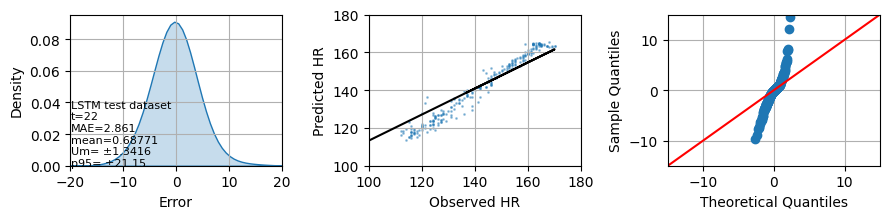

In [36]:
# graph the model performance

m, b = np.polyfit(y_test, pred_test, 1)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(9, 2.3)
sns.kdeplot( x=pred_test-y_test, fill=True, ax=ax1, common_norm=False)
ax2.scatter(x=y_test, y=pred_test, s=1, alpha=0.4)
ax2.plot(y_test, m*y_test + b, c='black')
sm.qqplot((pred_test-y_test), line ='45', ax=ax3)

ax1.set_xlim(-20,20)
ax1.set_xlabel('Error')
ax2.set_xlabel('Observed HR')
ax2.set_ylabel('Predicted HR')
ax2.set_xlim(100,180)
ax2.set_ylim(100,180)
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax1.text(-19.8,0.0,'LSTM test dataset\nt='+ str(n_y) + '\nMAE='+str(MAE_test) + "\nmean="+ str(round(mean_s,5)) + "\nUm= ±"+ str(round(mean_uncertainty,4))+'\np95= ±'+ str(round(test_sdev,2)) , fontsize=8 )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_t'+str(n_y)+'-'+str(n_X) +".png")


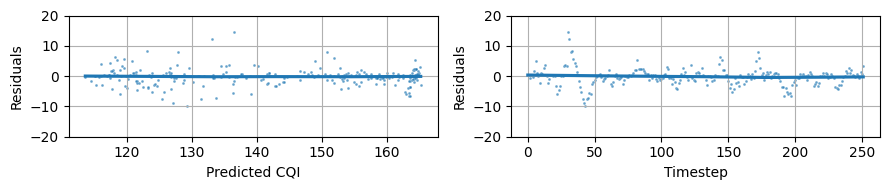

In [37]:
# further residuals plots
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(9, 2)

y_pred_error = (pred_test - y_test)
x_n = np.arange(0,len(y_pred_error))

sns.regplot(x=pred_test, y=y_pred_error, scatter=False,  ax=ax1, ci=95, lowess=True)
sns.regplot(x=x_n, y=y_pred_error, scatter=False,  ax=ax2, ci=95, lowess=True)
sns.scatterplot(x=pred_test, y=y_pred_error,  ax=ax1, alpha = 0.7, s=4)
sns.scatterplot(x=x_n, y=y_pred_error,  ax=ax2, alpha = 0.7, s=4)

ax2.set_ylim(-20,20)
ax1.set_ylim(-20,20)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Residuals')
ax1.set_xlabel('Predicted CQI')
ax1.set_ylabel('Residuals')
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.savefig(graph_path+'/HR_res_t'+str(n_y)+".png")